In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import scipy.stats as stt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('../input/heart.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
print(data.shape)
data.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Age histogramm show rather bimodal behavior than normal.

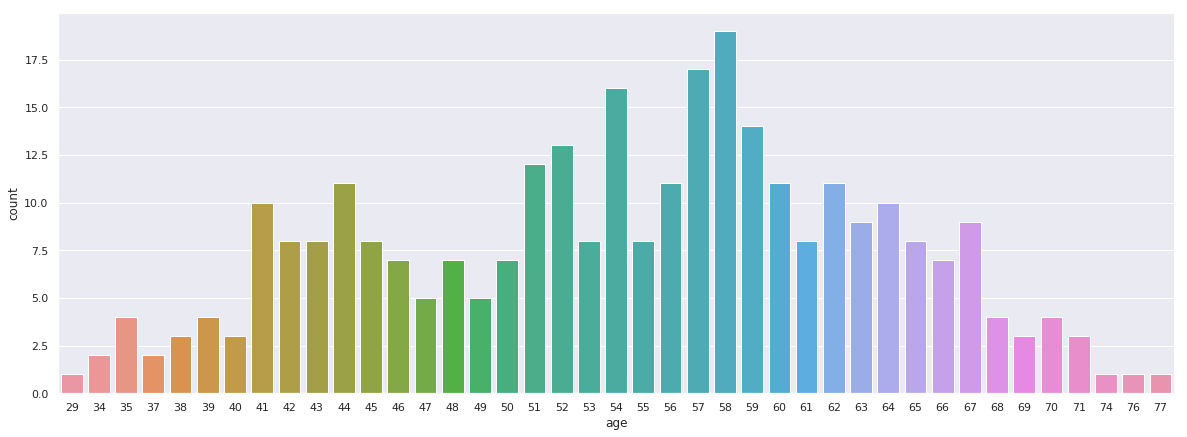

In [5]:
plt.figure(figsize=(20,7))
sns.set()
sns.countplot(data.age);

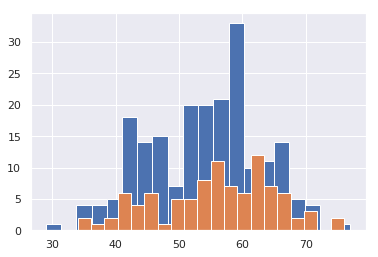

In [6]:
data[data.sex==1].age.hist(bins=20);
data[data.sex==0].age.hist(bins=20);

male/female age distribution in sample is equal, but different in count. It can be important.

In [7]:
print('mens in sample -  {:.2%}'.format(data[data.sex==1].shape[0]/data.shape[0]))

mens in sample -  68.32%


From this graphic we can see, that women in this sample sick much more often that men.

Men have disease:  0.4492753623188406
Women have disease:  0.75


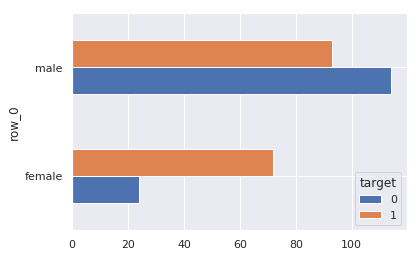

In [8]:
sex_str = np.where(data.sex==1, 'male', 'female')
pd.crosstab(sex_str, data.target).plot(kind='barh');

print("Men have disease: ",data[(data.sex==1)&(data.target==1)].shape[0]/data[(data.sex==1)].shape[0])
print("Women have disease: ",data[(data.sex==0)&(data.target==1)].shape[0]/data[(data.sex==0)].shape[0])

From this countplot we can see, that the danger of the disease is greatly increased from 43 years. But countplot below show that situation isn't bad and a lot if people are healthy in 54-65 years (peak in sample). It mean's that age feature is ambiguous and age don't show certainly probability of getting sick.

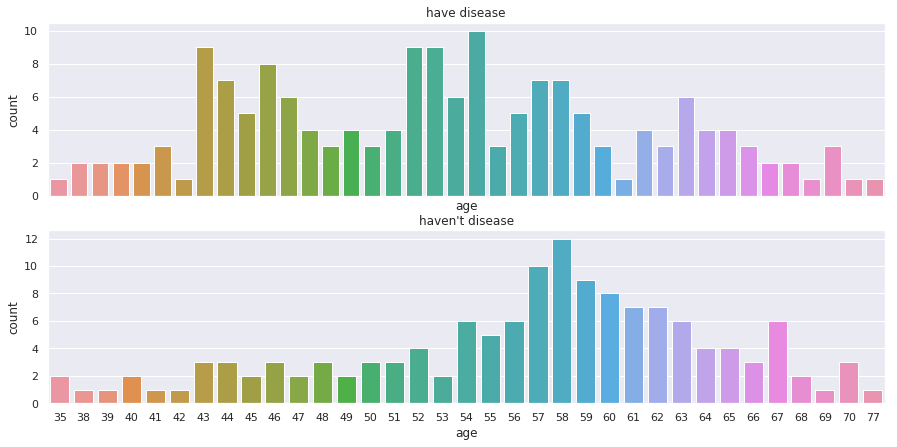

In [9]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(2,1,1)
ax1.set_title('have disease')
ax1.tick_params(labelbottom='off',axis='x')
sns.countplot(data[data.target==1].age);
ax2 = fig.add_subplot(2,1,2)
ax2.set_title("haven't disease")
sns.countplot(data[data.target==0].age);

Here we can see, that chest pain often means that the person is sick. But in about 24% still dangerous situation, when human don't feel pain, but have disease. So, cp feature is relevant.

Human have pain and disease: 76.36%


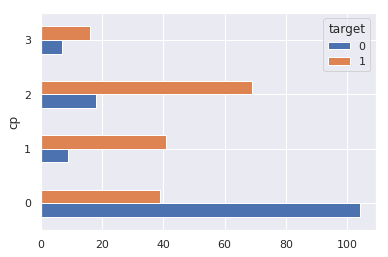

In [10]:
pd.crosstab(data.cp, data.target).plot(kind='barh');
print('Human have pain and disease: {:.4}%'.format(data[(data.target==1) & (data.cp!=0)].shape[0]/data[data.target==1].shape[0]*100))

It seems logical to check how related age and resting blood pressure (trestbps), but corrplot show very weak correlation.

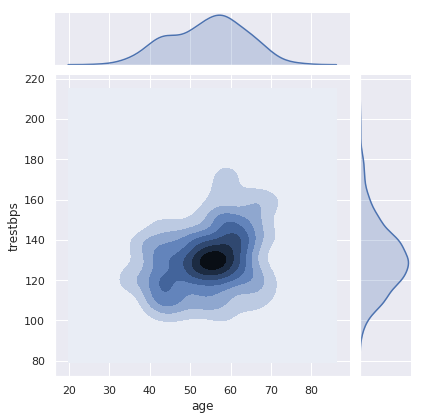

In [11]:
sns.jointplot(data.age, data.trestbps, kind='kde');

Here I cut age to some periods. We see same weak trend to high blood pressure by age, but we can't say anything about relation with blood pressure and taget. Means in disease/not disease slightly different, but IQR(Q3-Q1) doesnt support this assumption. 

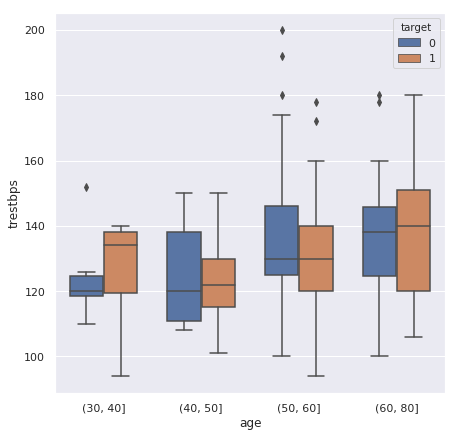

In [12]:
categ = pd.cut(data.age,[30,40,50,60,80])
dat_new = data[['target','trestbps']]
dat_new['age'] = categ
plt.figure(figsize=(7,7))
sns.boxplot(x='age',y='trestbps',hue='target',data=dat_new, width=0.7);

Remember the Sympson paradox, consider the main graphic with target/trestbps, and if show the same picture. So, feature trestbps is the first candidate to delete in feature list.

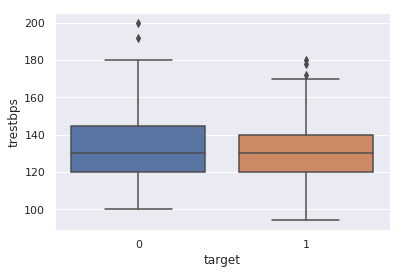

In [13]:
sns.boxplot(x=data.target, y=data.trestbps);

Cholesterol histogramm seems like normal distribution (with some emissions). By ttest we can see, that means are equal, that bad for predictive ability of this feature to the target value.

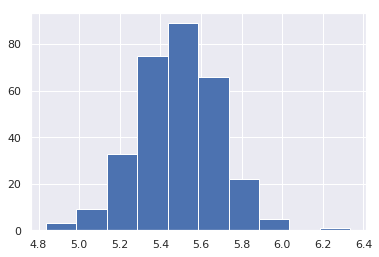

In [14]:
np.log(data.chol).hist();

Ttest_indResult(statistic=1.4842450762526975, pvalue=0.13879032695600646)

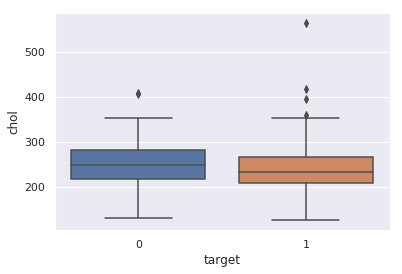

In [15]:
sns.boxplot(x=data.target, y=data.chol);
fst = data[data.target==0].chol
scd = data[data.target==1].chol
stt.ttest_ind_from_stats(fst.mean(),fst.std(),fst.shape[0],\
                         scd.mean(),scd.std(),scd.shape[0],equal_var=True)

Now consider corrplot with all metrical data. This corrplot can't show any high relation.

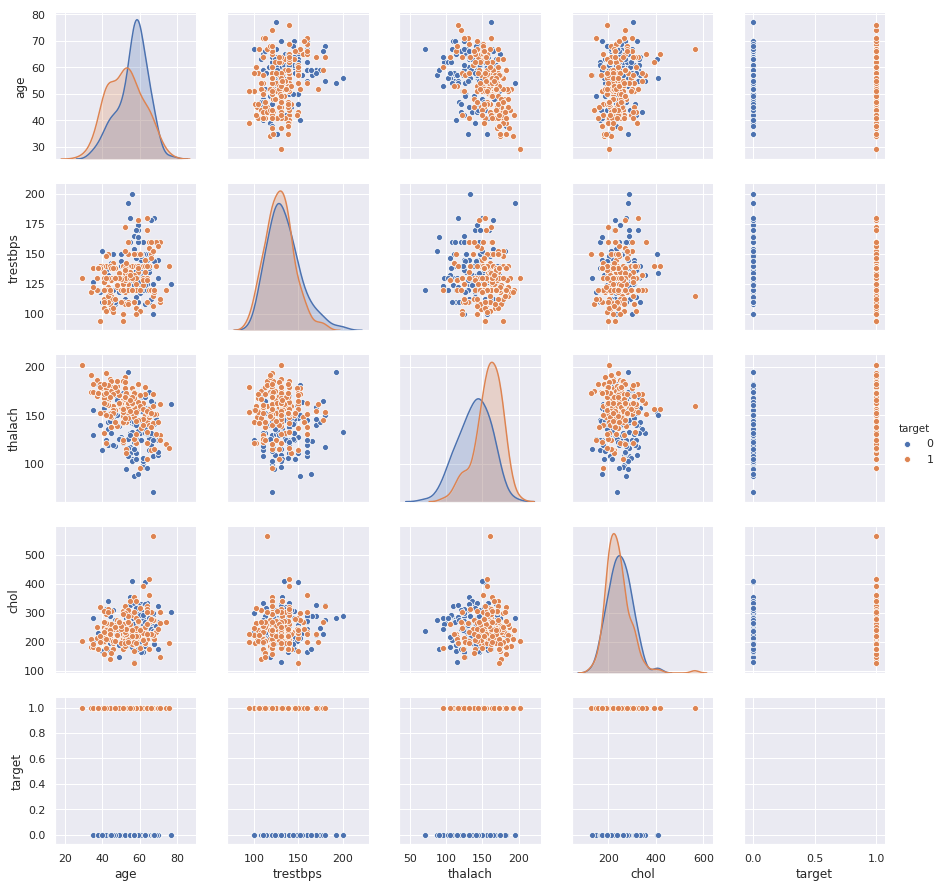

In [16]:
sns.pairplot(data[['age','trestbps','thalach','chol','target']],hue='target',size=2.5);

See to the fbs-feature. This crosstab show that when fasting blood sugar < 120, probability of disease is higher. But this relation isn't high.

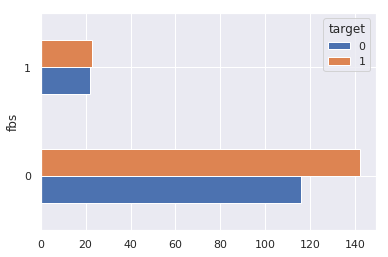

In [17]:
pd.crosstab(data.fbs,data.target).plot(kind='barh');

And the thalach-feature show high differences in disease/not disease. This feature can be relevant. 
Finally, compare all metric data in boxplots. Best features are thalach, age and oldpeak.

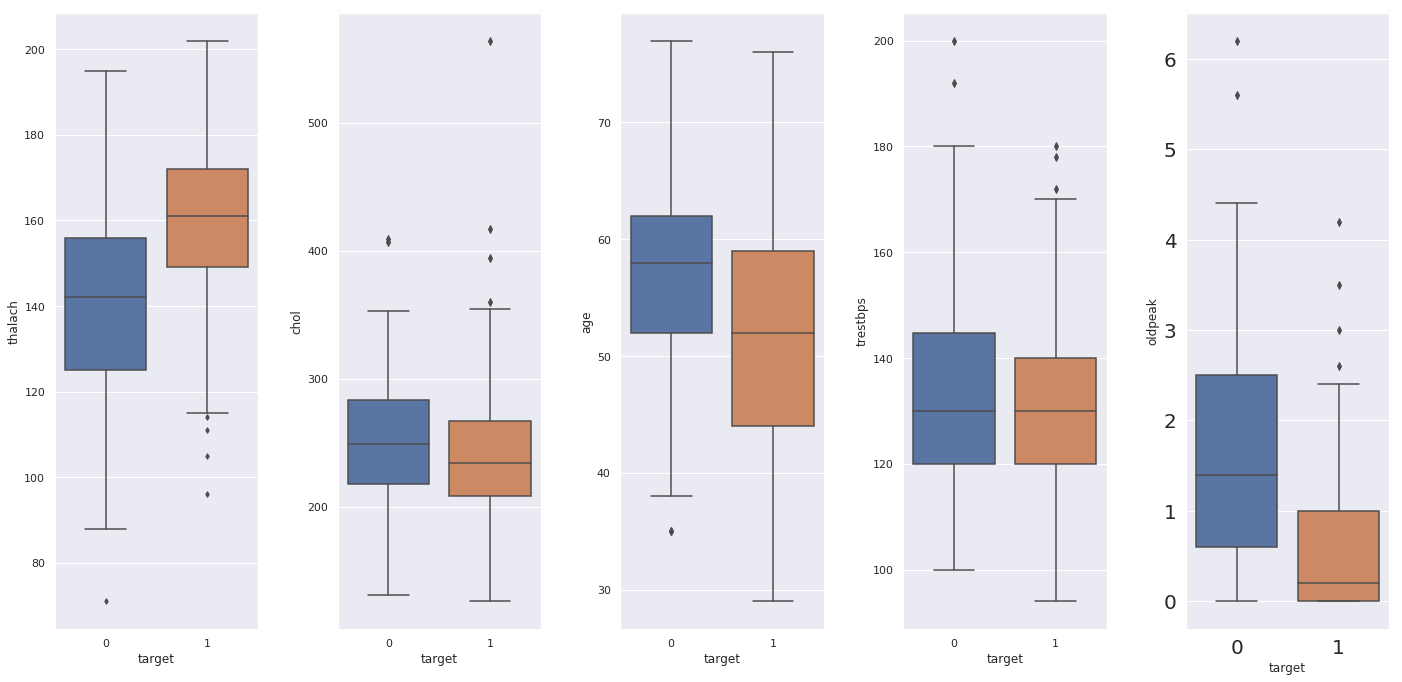

In [18]:
f, axes = plt.subplots(1, 5,figsize=(20,10))
sns.set(font_scale=2)
sns.boxplot(x=data.target, y=data.thalach, ax=axes[0],fliersize=4);
sns.boxplot(x=data.target, y=data.chol, ax=axes[1]);
sns.boxplot(x=data.target, y=data.age, ax=axes[2]);
sns.boxplot(x=data.target, y=data.trestbps, ax=axes[3]);
sns.boxplot(x=data.target, y=data.oldpeak, ax=axes[4]);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()

Consider last cathegorical features. They are important and show relations with target.

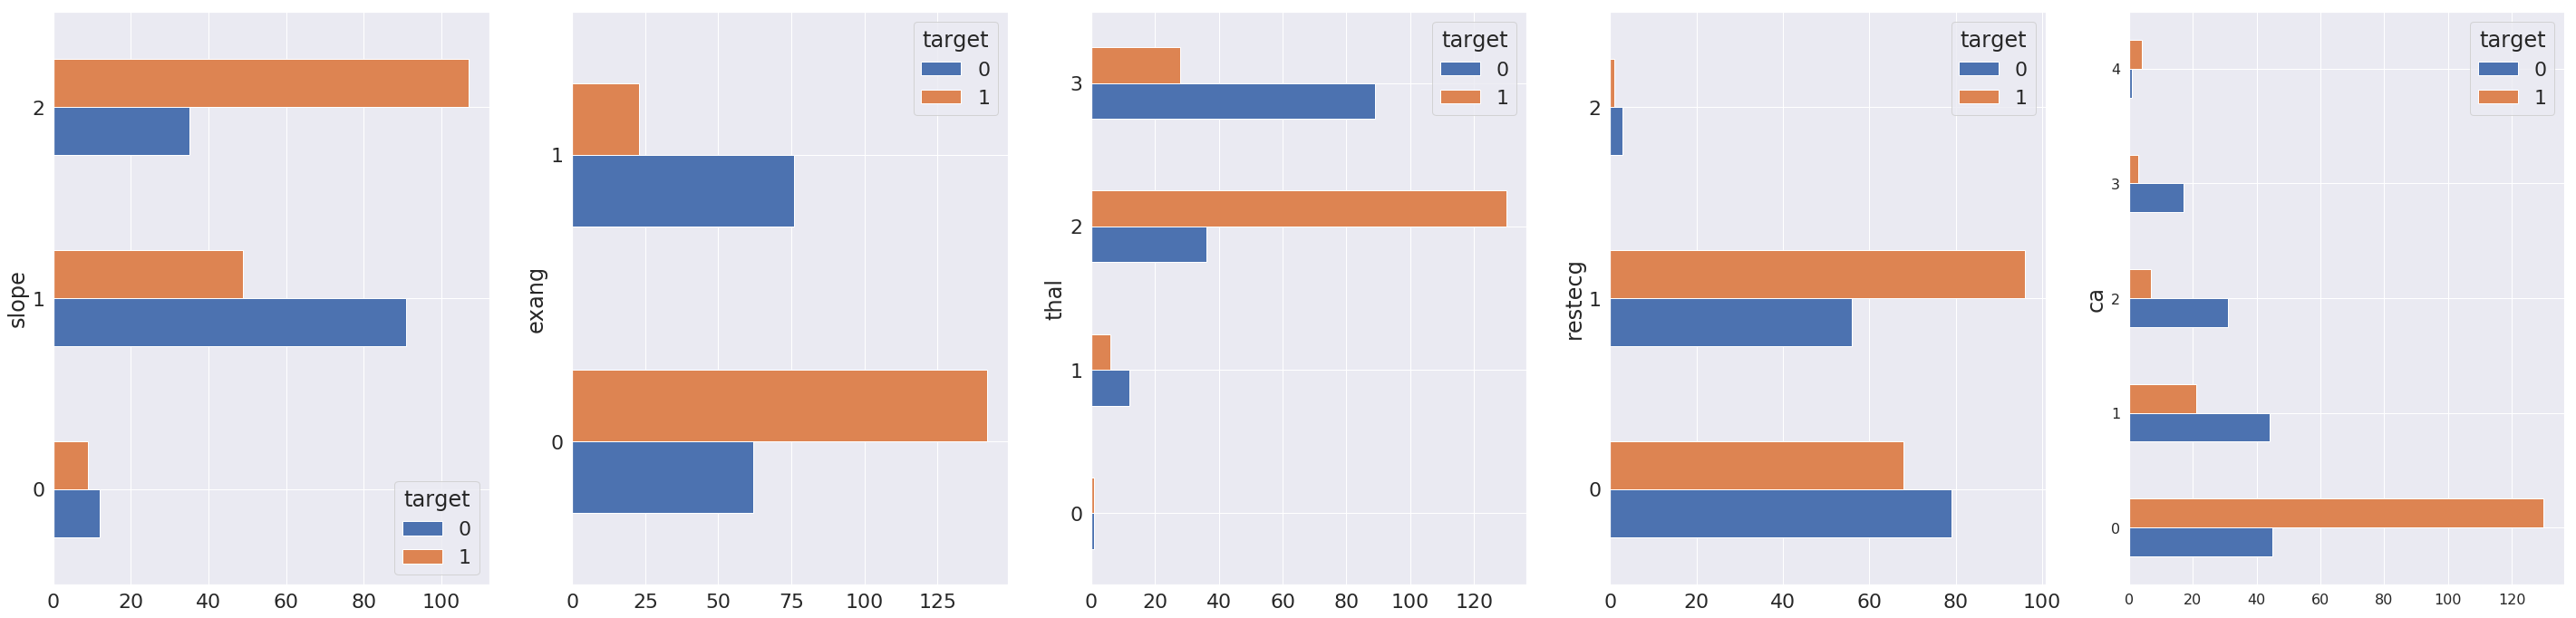

In [19]:
f, axes = plt.subplots(1, 5,figsize=(40,10))
sns.set(font_scale=2)
pd.crosstab(data.slope,data.target).plot(kind='barh', ax=axes[0]);
pd.crosstab(data.exang,data.target).plot(kind='barh', ax=axes[1]);
pd.crosstab(data.thal,data.target).plot(kind='barh', ax=axes[2]);
pd.crosstab(data.restecg,data.target).plot(kind='barh', ax=axes[3]);
pd.crosstab(data.ca,data.target).plot(kind='barh', ax=axes[4]);
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()

Crosstab with sex and (slope/thal/exang) show that they are related. It's nean that together with sex this features can work better. 

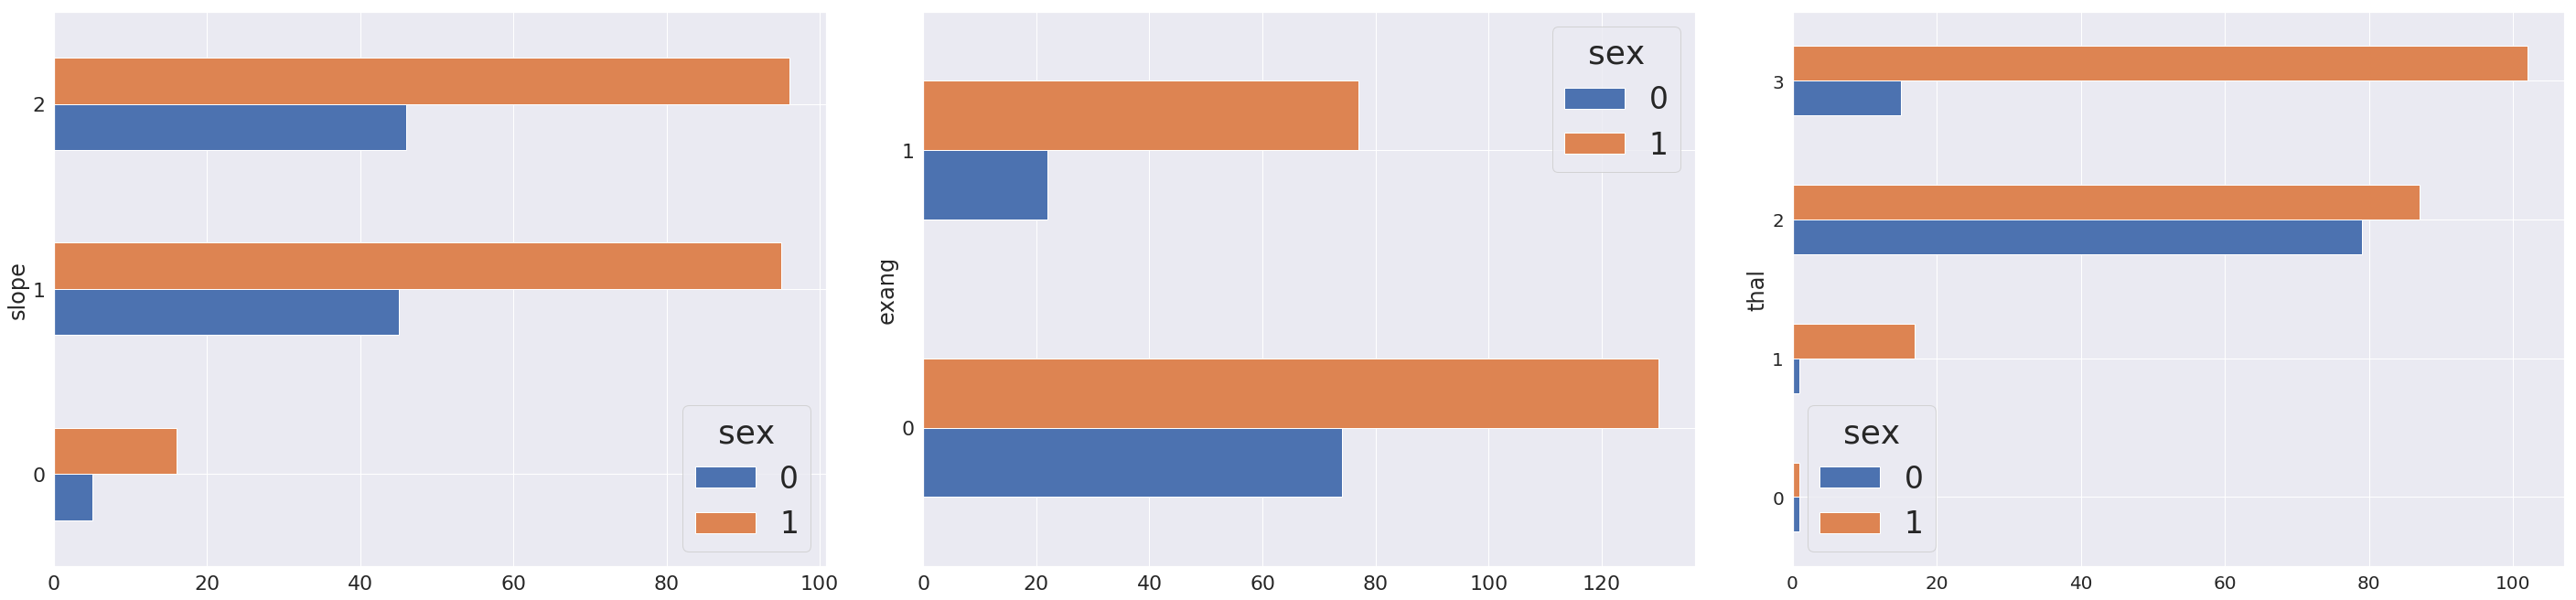

In [20]:
f, axes = plt.subplots(1, 3,figsize=(40,10))
sns.set(font_scale=3)
pd.crosstab(data.slope,data.sex).plot(kind='barh', ax=axes[0]);
pd.crosstab(data.exang,data.sex).plot(kind='barh', ax=axes[1]);
pd.crosstab(data.thal,data.sex).plot(kind='barh', ax=axes[2]);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()

Classes are just about the same:

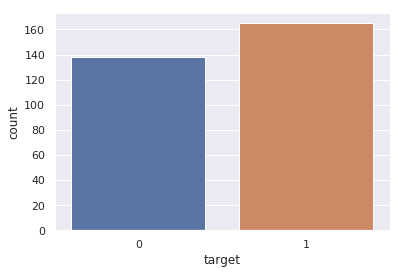

In [21]:
sns.set(font_scale=1)
sns.countplot(data.target);

Finally, after all manipulations with data, I will leave age, sex, cp, thalach, exang, oldpeak, slope, ca and thal. Many features are cathegroical, therefore to facilitate the solution of the problem, I use trees methods. And for n_estimators=100 for RandomForest these set of features gives more AUC-score than set from all features.

In [22]:
data_train, data_test, targ_train, targ_test = train_test_split(\
            data[['age','sex','cp','thalach','exang','oldpeak','slope','ca','thal']], data.target, test_size=0.2)

In [23]:
forest = RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=4)
forest.fit(data_train, targ_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
labels = forest.predict(data_test)
sns.set(font_scale=1.5)
auc = roc_auc_score(labels, targ_test)
fpr, tpr, thresholds = roc_curve(labels,targ_test)
print('ROC curve: AUC={0:0.2f}'.format(auc));

ROC curve: AUC=0.81


Dataset is small, so we can apply cross validation. And this score doesn't show big deviations from our prediction.

In [25]:
scores = cross_val_score(forest, data[['age','sex','cp','thalach','exang','oldpeak','slope','ca','thal']], data.target, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.82 (+/- 0.10)


In [26]:
print(classification_report(labels,targ_test))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79        28
           1       0.81      0.88      0.84        33

    accuracy                           0.82        61
   macro avg       0.82      0.81      0.82        61
weighted avg       0.82      0.82      0.82        61



Here we can see feature importances from this model

In [27]:
forest.feature_importances_

array([0.06944357, 0.02834415, 0.14781547, 0.14191381, 0.06980554,
       0.12897051, 0.05703687, 0.16773491, 0.18893518])

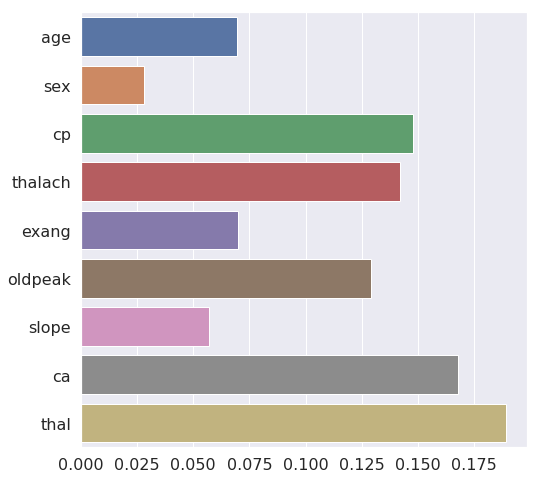

In [28]:
feat_imp = pd.DataFrame(forest.feature_importances_, index = ['age','sex','cp','thalach','exang','oldpeak','slope','ca','thal'])
plt.figure(figsize=(8,8));
sns.barplot(feat_imp[0],feat_imp.index);
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('');

So we can get simple forest classifier for this dataset. <br>
Thank you for reading! I hope this kernel  was helpful for you.